In [27]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np
from math import sqrt, pi

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm
from copy import deepcopy

## Min Config

In [28]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EXPERIMENT = 'CIRCLE2CIRCLE'
T_ITERS = 10 # how much T updates to do per 1 update of f

ZD = 2
Z_STD = 0.2 # 0. w/o kernel reg.
Z_SIZE = 8
COST = 'energy'
GAMMA = 0.4 # 0. w/o kernel reg. 
DIM = 2

if EXPERIMENT in ['CIRCLE2CIRCLE']:
    MAX_STEPS = 70000 # total number of training steps
    W0 = 1
    W1 = 1 # 2/2, 2/1
    W_ITERS = 4000

In [29]:
# Use these functions to sample from the distributions

def sample_from_tensor(t, size=64, loc=-1):
    coords = (torch.rot90(t, -1, [0, 1]) == 1).nonzero(as_tuple=False).detach().cpu().numpy() / 32 / 32 + loc 
    indices = random.choices(range(len(coords)), k=size)
    xy = coords[indices]
    return xy.astype(np.float32)

def sample_mixture_sphere(size=64, centerX=0, centerY=0, R=0.7, eps=0.1):
    Rs = np.array([(R,)])
    indices = random.choices(range(len(Rs)), k=size)
    radiuses = Rs[indices] + (np.random.random(size=(size, 1)) - 1) * eps
    theta = np.random.random(size=(size, 1)) * pi * 2
    x = centerX + radiuses * np.cos(theta)
    y = centerY + radiuses * np.sin(theta)
    return np.concatenate((x, y), axis=1).astype(np.float32)

def circle_from_tensor(t, size=64, loc=-1, scale=(1, 1)):
    coords = ((torch.rot90(t, -1, [0, 1]) == 1).nonzero(as_tuple=False).detach().cpu().numpy()) + loc 
    indices = random.choices(range(len(coords)), k=size)
    xy = coords[indices]
    return xy.astype(np.float32)

def sample_normal(size=64, loc=(0, 0), scale=(0.2, 0.2)):
    return np.random.normal(size=(size,2), loc=loc, scale=scale).astype(np.float32)

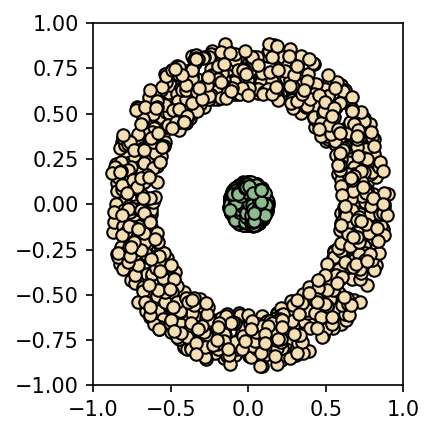

In [30]:
if EXPERIMENT == 'CIRCLE2CIRCLE':
    im = Image.open('circle.png')
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((32*8, 32*8)),
                                   ])
    t = transform(im)[0].float()
    t1 = (t < 0.5).float()
    
    X = sample_from_tensor(t1, 1024, loc=(-0.125, -0.125))
    
    Y = sample_mixture_sphere(size=1024, eps=0.3, R=0.9)
    fig, axes = plt.subplots(1, 1, figsize=(3,3), dpi=150, sharex=True, sharey=True)
    axes.set_xlim(-1, 1);
    axes.set_ylim(-1, 1);
    
axes.scatter(X[:,0], X[:, 1], c='darkseagreen', edgecolors='black')
axes.scatter(Y[:,0], Y[:, 1], c='wheat', edgecolors='black')
fig.tight_layout()

## Initializing networks

In [31]:
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')


class NegAbs(nn.Module):
    def __init__(self):
        super(NegAbs, self).__init__()

    def forward(self, input):
        return -torch.abs(input)
        
if EXPERIMENT == 'CIRCLE2CIRCLE':
    T = nn.Sequential(
        nn.Linear(2+ZD, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 2),
    ).to(DEVICE)

    f = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 1),
        NegAbs(),
    ).to(DEVICE)
    
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

T.apply(weights_init_mlp); f.apply(weights_init_mlp)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 528898
f params: 527361


In [38]:
T_opt = torch.optim.AdamW(T.parameters(), lr=1e-6, weight_decay=1e-10)
f_opt = torch.optim.AdamW(f.parameters(), lr=1e-6, weight_decay=1e-10)

In [33]:
if EXPERIMENT in ['CIRCLE2CIRCLE']:
    X_fixed = sample_from_tensor(t1, 1024, loc=(-0.125, -0.125))
    Y_fixed = sample_mixture_sphere(size=1024, eps=0.3, R=0.9)
    X_fixed = torch.tensor(X_fixed, device='cuda')
    Z_fixed = torch.randn(1024, ZD, device='cuda') * Z_STD
    XZ_fixed = torch.cat([X_fixed, Z_fixed], dim=1)

## Training

Step 4600


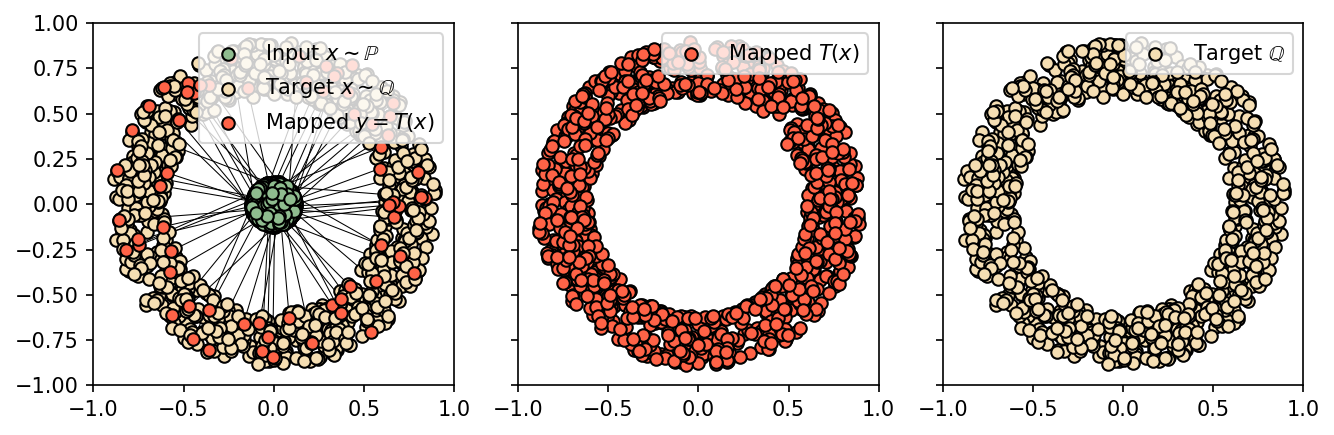

KeyboardInterrupt: 

In [63]:
# NOT perfect algorithm
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    try:
        W = min(W1, W0 + (W1-W0) * step / W_ITERS)
    except:
        W = W1
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        if EXPERIMENT in ['CIRCLE2CIRCLE']:
            X = sample_from_tensor(t1, 1024, loc=(-0.125, -0.125))
            X = torch.tensor(X, device=DEVICE)
            X = X.reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)
            with torch.no_grad():
                Z = torch.randn(1024, Z_SIZE, ZD, device='cuda') * Z_STD
                XZ = torch.cat([X, Z], dim=2)
                
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1, 0).reshape(DIM, -1, Z_SIZE).permute(1, 2, 0)

        if COST == 'energy':
            T_loss = (X-T_XZ).norm(dim=2).mean() - f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() -\
            GAMMA * .5 * torch.cdist(T_XZ, T_XZ).mean() * Z_SIZE / (Z_SIZE -1)
        
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    if EXPERIMENT in ['CIRCLE2CIRCLE']:
        X = sample_from_tensor(t1, 1024, loc=(-0.125, -0.125))
        Y = sample_mixture_sphere(size=1024, eps=0.3, R=0.9)
        
    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    with torch.no_grad():
        Z = torch.randn(1024, ZD, device='cuda') * Z_STD
        XZ = torch.cat([X, Z], dim=1)
        T_XZ = T(XZ)


    f_loss = f(T_XZ).mean() - (W * f(Y)).mean()
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 100 == 0:
        clear_output(wait=True)
        print("Step", step)

        # The code for plotting the results
        fig, axes = plt.subplots(1, 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
        X_fixed = torch.tensor(X_fixed, device=DEVICE)
        XZ_fixed = torch.tensor(XZ_fixed, device=DEVICE)
        
        with torch.no_grad():
            T_XZ_fixed = T(XZ_fixed).to('cpu').numpy()
            X_fixed = X_fixed.to('cpu').numpy()
        lines =  list(zip(X_fixed[:64], T_XZ_fixed[:64]))
        lc = mc.LineCollection(lines, linewidths=0.5, color='black')
        
        axes[0].add_collection(lc)

        axes[0].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
        axes[0].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', zorder=2, label=r'Target $x\sim\mathbb{Q}$')        
        axes[0].scatter(T_XZ_fixed[:64,0], T_XZ_fixed[:64, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
        axes[1].scatter(T_XZ_fixed[:,0], T_XZ_fixed[:, 1], c='tomato', edgecolors='black', label=r'Mapped $T(x)$')
        axes[2].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $\mathbb{Q}$')
        axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right')

        if EXPERIMENT in ['CIRCLE2CIRCLE']:
            axes[0].set_xlim(-1, 1);
            axes[1].set_ylim(-1, 1);

        fig.tight_layout(); plt.show()

## Visualization

<ipython-input-85-e4b50ae87e05>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XZ_fixed = torch.tensor(XZ_fixed, device=DEVICE)


tensor(0.1377, device='cuda:0')
tensor(0.0730, device='cuda:0')
tensor(0.0495, device='cuda:0')


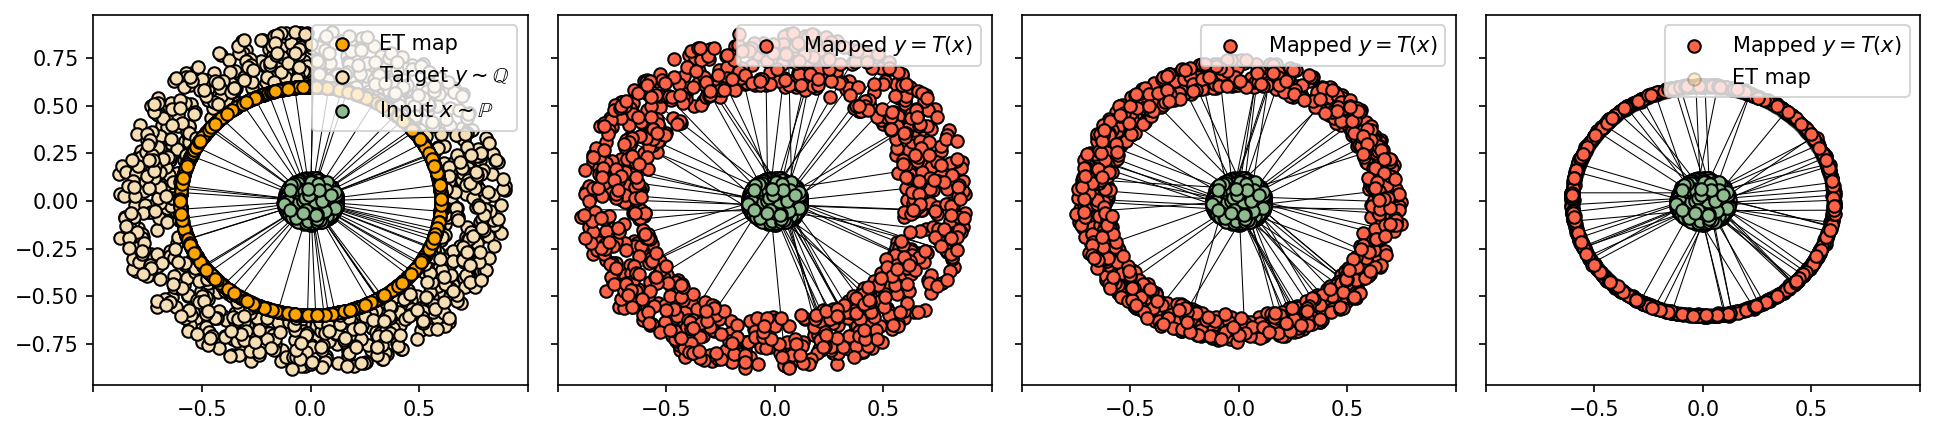

In [85]:
fig, axes = plt.subplots(1, 4, figsize=(13,3), dpi=150, sharex=True, sharey=True)

X_fixed = sample_from_tensor(t1, 1024, loc=(-0.125, -0.125))
X_fixed = torch.tensor(X_fixed).cuda()
nn = ( 
    X_fixed * (0.7 - 0.1) / X_fixed.square().sum(axis=1).sqrt()[:, None]
)
nn = nn.to('cpu').numpy()
X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], nn[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')

axes[0].add_collection(lc)
axes[0].scatter(nn[:,0], nn[:, 1], c='orange', edgecolors='black', label=r'ET map', zorder=3)
axes[0].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', zorder=1, label=r'Target $y\sim\mathbb{Q}$')
axes[0].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')

X_fixed = torch.tensor(X_fixed).cuda()
XZ_fixed = torch.tensor(XZ_fixed, device=DEVICE)

T.eval();
T.load_state_dict(torch.load('../checkpoints/circle2circle_IT_T_1_10K.pth'))
with torch.no_grad():
    T_XZ_fixed = T(XZ_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_XZ_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_XZ_fixed, device='cuda')).mean())

axes[1].add_collection(lc)
axes[1].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[1].scatter(T_XZ_fixed[:,0], T_XZ_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
del T_XZ_fixed

X_fixed = torch.tensor(X_fixed).cuda()
T.eval();
T.load_state_dict(torch.load('../checkpoints/circle2circle_IT_T_2_15K.pth'))
with torch.no_grad():
    T_XZ_fixed = T(XZ_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_XZ_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_XZ_fixed, device='cuda')).mean())

axes[2].add_collection(lc)
axes[2].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[2].scatter(T_XZ_fixed[:,0], T_XZ_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
del T_XZ_fixed

X_fixed = torch.tensor(X_fixed).cuda()
T.eval();
T.load_state_dict(torch.load('../checkpoints/circle2circle_IT_T_32_20K.pth'))
with torch.no_grad():
    T_XZ_fixed = T(XZ_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_XZ_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_XZ_fixed, device='cuda')).mean())

axes[3].add_collection(lc)
axes[3].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[3].scatter(T_XZ_fixed[:,0], T_XZ_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
axes[3].scatter(nn[:,0], nn[:, 1], c='orange', edgecolors='black', label=r'ET map', zorder=2, alpha=0.2)

axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); 
axes[2].legend(loc='upper right'); axes[3].legend(loc='upper right');

for ax in axes:
    xticks = ax.xaxis.get_major_ticks()
    xticks[0].label1.set_visible(False)
    xticks[-1].label1.set_visible(False)

axes[0].set_xlim(-1, 1);
fig.tight_layout(); plt.show()